## This notebook is for providing analysis for Task 1 through Task 3


## magic shortcuts:

* [Task 1](#Q1) : Download data

* [Task 2](#Q2) : Trip distance analysis & modeling

* [Task 3](#Q3) : Some interesting patterns of trips around airports

<a id = Q1> </a>
## Task 1

* 1.1 Programmatically download and load into your favorite analytical tool the trip data for September 2015.
* 1.2 Report how many rows and columns of data you have loaded.

In [1]:
# load library
import urllib.request as downloader # download
import os
import pandas as pd # data analysis
import seaborn as sns # visualization
import numpy as np
%matplotlib inline

In [2]:
def download_data():  
    """
    Download and save data at 'current_dir/data/'
    
    """
    # check if folder already exists in current dirctory, create one if not
    data_folder = os.getcwd() + '/data'
    if not os.path.exists(data_folder):
        os.mkdir(data_folder)
        
    # check if file already exists, download data if not
    data_file = data_folder + '/green_tripdata_2015-09.csv'
    
    if not os.path.exists(data_file):
        # download
        url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
        downloader.urlretrieve(url, data_file)
        
        # check if download is complete
        downloaded = os.stat(data_file)[6] # downloaded data size
        # total size
        total_size = downloader.urlopen(url).getheaders()[-3][1]
        
        if downloaded == int(total_size):
            print('file has been saved as: ' + data_file)
        else:
            print('incomplete download, please retry')
    
    else:
        print('file already exists!')

In [3]:
download_data()

file already exists!


In [4]:
# load data into pandas
dataset = pd.read_csv('./data/green_tripdata_2015-09.csv')

# reaport rows and columns have been loaded
print('%i rows and %i columns have been loaded' % (dataset.shape[0], dataset.shape[1]))

1494926 rows and 21 columns have been loaded


<a id = Q2> </a>
## Task 2
* 2.1 Plot a histogram of the number of the trip distance ("Trip Distance").
* 2.2 Report any structure you find and any hypotheses you have about that structure.

### overall trip distance distribution

(0, 700.0)

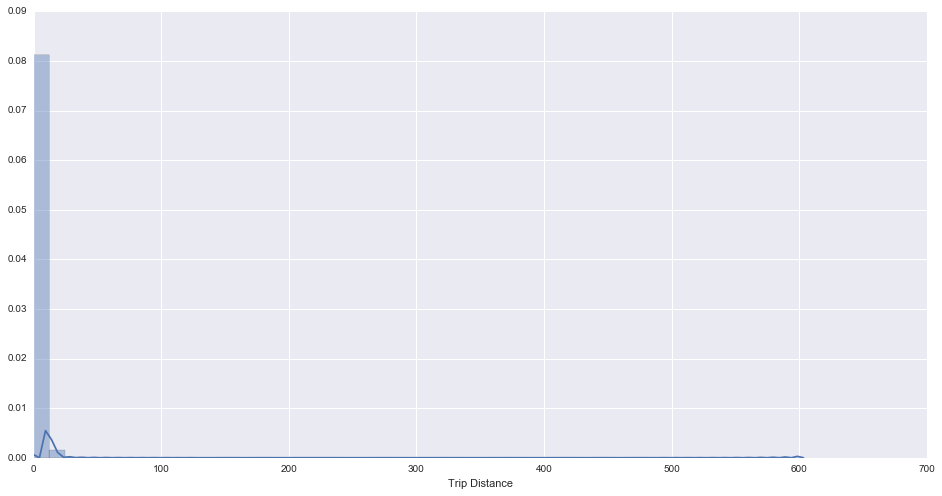

In [43]:
sns.set(rc={"figure.figsize": (16, 8)});
hist1 = sns.distplot(dataset.Trip_distance, axlabel = 'Trip Distance')
axes = hist1.axes
axes.set_xlim(0, )

### To get a closer view of the high-piked trip distance distribution, we will only look at the trips less than 20 miles

(0, 25.0)

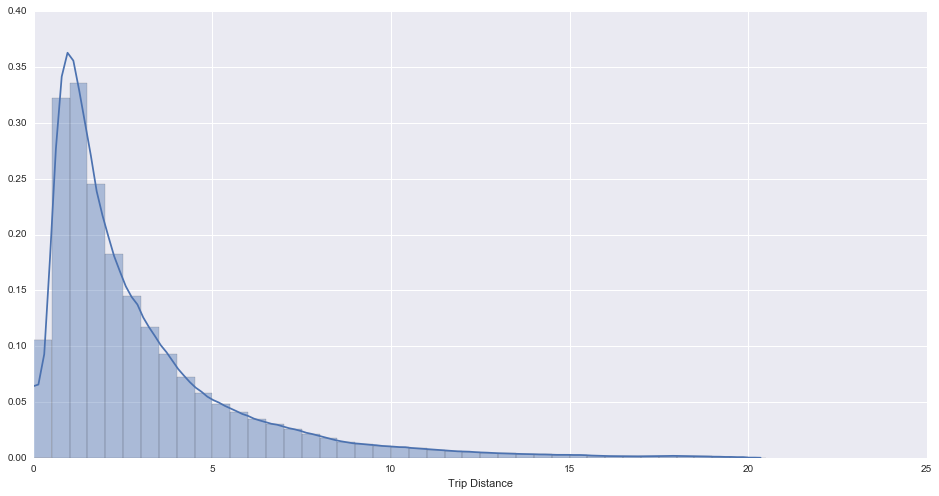

In [140]:
hist2 = sns.distplot(dataset.Trip_distance.loc[dataset.Trip_distance < 20], 
                     bins = np.arange(0, 20 + 1, .5), axlabel = 'Trip Distance')
axes = hist2.axes
axes.set_xlim(0, )

In [129]:
# summary statistics
pd.options.display.float_format = '{:,.3f}'.format
dataset.Trip_distance.loc[dataset.Trip_distance < 20].describe()

count   1,491,532.000
mean            2.916
std             2.806
min             0.000
25%             1.090
50%             1.970
75%             3.720
max            19.990
Name: Trip_distance, dtype: float64

### Hypothesis summary and testing

The distribution plot above suggests a positive association between trip distance and number of demands for green cabs when the distance ranges from 0 to approximately 1.5 miles. A similar negative association applies at the distance above 1.5 miles.

The shape of the density curve indicates that the trip distance might follow Poisson distribution if we treat the population density as the probability that a given trip might occur within a population. To further investigate this hypothesis, let's try to use Maximum Likelihood Estimation (MLE) to infer the parameter of Poisson distribution and plot predicted probability and the actual probability (population density) together to evaluate model performance:

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in power
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log


   direc: array([[-0.01049886]])
     fun: 3548042.2772550252
 message: 'Optimization terminated successfully.'
    nfev: 44
     nit: 2
  status: 0
 success: True
       x: array(2.916112850903603)


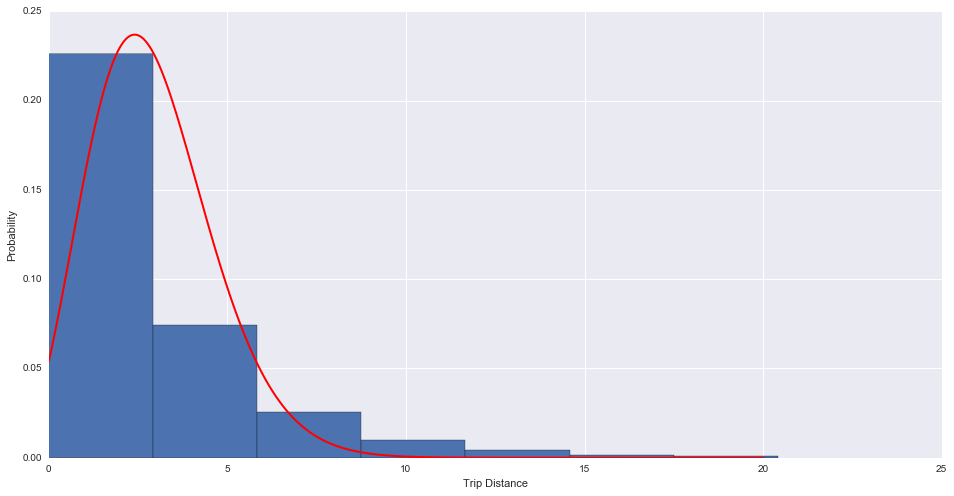

In [142]:
# code borrowed from: http://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.misc import factorial


def poisson(k, lamb):
    """poisson pdf, parameter lamb is the fit parameter"""
    return (lamb**k/factorial(k)) * np.exp(-lamb)


def negLogLikelihood(params, data):
    """ the negative log-Likelohood-Function"""
    lnl = - np.sum(np.log(poisson(data, params[0])))
    return lnl

# get poisson deviated random numbers
data = dataset.Trip_distance.loc[(dataset.Trip_distance < 20)].as_matrix()

# minimize the negative log-Likelihood
result = minimize(negLogLikelihood,  # function to minimize
                  x0=np.ones(1),     # start value
                  args=(data,),      # additional arguments for function
                  method='Powell',   # minimization method
                  )
# result is a scipy optimize result object, the fit parameters 
# are stored in result.x
print(result)

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 20, 1000)
binwidth = float(result.x)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('Trip Distance')
ax.set_ylabel('Probability')

ax.hist(data,bins=np.arange(0, 20 + binwidth, binwidth), normed = True) # histogram shows actual distribution
ax.plot(x_plot, poisson(x_plot, result.x), 'r-', lw=2) # red density curve shows predicted probability

plt.show()

### Conclusion
Using MLE, we inferred the parameter of Poisson distribution: $\lambda$ to be 2.916. Under the assumption of Poisson Distribution, this means the average rate that a trip might occur equals to the rate that a trip with distance 2.916 miles might occur.

The plot above suggests the Poisson model gives a good prediction at the first and third bin (0-2.916 miles interval and 2.916*3-2.916*4 miles interval). However, the model overestimates at the second bin and underestimates at the fourth and the rest bins. This might be caused by the violation of event independence assumption in Poisson model. Say, the total number of green cabs in NYC is constant. The more short-distance trips occur, which means the more number of cabs will be occupied, the less long-distance trips will happen, which violates the assumption of independence.

<a id = Q3> </a>
## Task 3
* 3.1 Report mean and median trip distance grouped by hour of day.
* 3.2 We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips.


### <font color='blue'> MEAN </font> trip distance grouped by hour of day

In [143]:
times = pd.DatetimeIndex(dataset.lpep_pickup_datetime)
dataset.Trip_distance.groupby(times.hour).mean()

0    3.115
1    3.017
2    3.046
3    3.213
4    3.527
5    4.133
6    4.055
7    3.284
8    3.048
9    2.999
10   2.944
11   2.912
12   2.903
13   2.878
14   2.864
15   2.857
16   2.780
17   2.679
18   2.653
19   2.716
20   2.777
21   2.999
22   3.185
23   3.192
Name: Trip_distance, dtype: float64

### <font color='green'> MEDIAN </font> trip distance grouped by hour of day

In [144]:
times = pd.DatetimeIndex(dataset.lpep_pickup_datetime)
dataset.Trip_distance.groupby(times.hour).median()

0    2.200
1    2.120
2    2.140
3    2.200
4    2.360
5    2.900
6    2.840
7    2.170
8    1.980
9    1.960
10   1.920
11   1.880
12   1.890
13   1.840
14   1.830
15   1.810
16   1.800
17   1.780
18   1.800
19   1.850
20   1.900
21   2.030
22   2.200
23   2.220
Name: Trip_distance, dtype: float64

### Next, let's look at trips started or ended near airports

In [147]:
import geopandas as gpd # for processing geographical data
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point, Polygon, LineString
import pickle

We will limit our analysis to two major airports in NYC- John F. Kennedy and LaGardia Airport

In [149]:
# John F. Kennedy International Airport, JFK, 40.6413° N, 73.7781° W
# use a polygon to represent the geographics of JFK airport, coordinates data from Google Map
jfk = Polygon([(40.667526, -73.780606), (40.666048, -73.833996),
               (40.652695, -73.831703), (40.648452, -73.823428),
               (40.648452, -73.823428), (40.635432, -73.748500),
               (40.644745, -73.747620)
              ])

# LaGuardia Airport, LGA, 40.7769° N, 73.8740° W
laguardia = Polygon([(40.773460, -73.890349), (40.766775, -73.887669),
                    (40.771625, -73.872679), (40.765005, -73.862025),
                    (40.772087, -73.855024), (40.786058, -73.871229),
                    (40.779948, -73.885207)])

In [151]:
# define a function that determines if a trip started or ended near John F. Kennedy International Airport or LaGuardia Airport
def nearAirport(pickup_point, dropoff_point):
    '''
    return True if a trip started or ended near John F. Kennedy International Airport or LaGuardia Airport
    return Flase otherwise
    
    args: 
        pickup_point -- coordinate of pickup point, eg. (40.773460, -73.890349)
        dropiff_point -- coordinate of dropoff point, eg. (40.773460, -73.890349) 
    
    '''
    pickup_point = Point(pickup_point)
    dropoff_point = Point(dropoff_point)
    return (jfk.contains(pickup_point) | laguardia.contains(pickup_point) | 
            jfk.contains(dropoff_point) | laguardia.contains(dropoff_point))

In [154]:
# apply nearApriort() function to the dataset, this can be a computationally expensive job, will save the results
# for future reference
trip_near_airport = dataset.apply(lambda x: nearAirport((x[['Pickup_latitude','Pickup_longitude']]),
                                                 (x[['Dropoff_latitude','Dropoff_longitude']])), axis = 1)

In [ ]:
# save for future reference
with open('./data/trip_near_airport.p', 'wb') as handle:
    pickle.dump(trip_near_airport, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [155]:
# next time, load from pickle
trip_near_airport = pickle.load(open('./data/trip_near_airport.p', 'rb' ))

### Transactions happened near John F. Kennedy or LaGuardia Airport:

In [158]:
print ('In total, %i trainsactions either originate or terminate near\
 John F. Kennedy International Airport or LaGuardia Airport' % trip_near_airport.sum())

In total, 35370 trainsactions either originate or terminate near John F. Kennedy International Airport or LaGuardia Airport


### Average fare of the trips happened near the two airports vs. other places

In [169]:
avg_fair_airport = dataset['Fare_amount'][trip_near_airport].mean()
avg_fair_other = dataset['Fare_amount'][-trip_near_airport].mean()

print ('The average fair the trips happend near the two airports is: $%.2f, \n while \
the average fair at other places is: $%.2f.' % (avg_fair_airport, avg_fair_other))

The average fair the trips happend near the two airports is: $28.27, 
 while the average fair at other places is: $12.16.


### Average percentage of tips of the trips happened near the two airports vs. other places

In [186]:
avg_tip_percent_airport = dataset['Tip_amount'][trip_near_airport].mean() / avg_fair_airport
avg_tip_percent_other = dataset['Tip_amount'][-trip_near_airport].mean() / avg_fair_airport

print ('The average percentage of tips of the trips happend near the two airports is: %.2f%% , \n while \
the average percentage of tips at other places is: %.2f%%.' % (avg_tip_percent_airport * 100, avg_tip_percent_other * 100))

The average percentage of tips of the trips happend near the two airports is: 13.54% , 
 while the average percentage of tips at other places is: 4.15%.


It looks like passengers who headed to or away from airports like to pay more tips than others do.